In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import randint
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

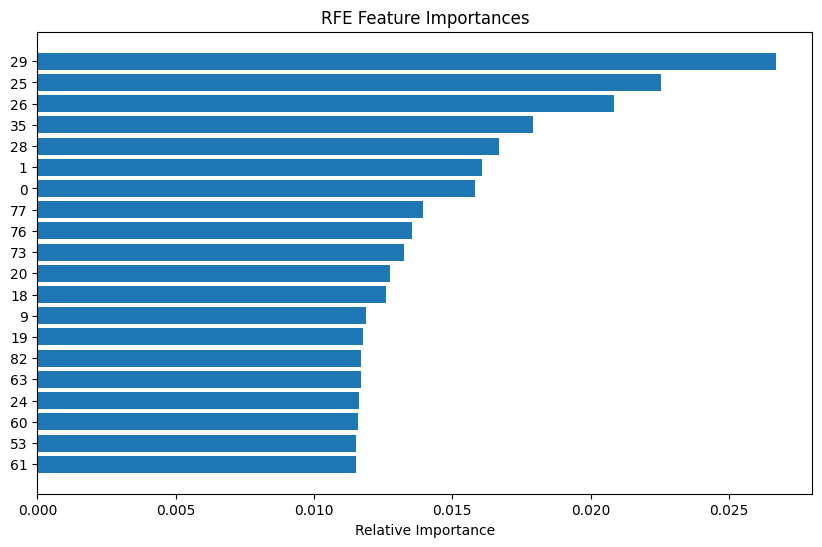


RFE-Based Model Results:
Best Params: {'bootstrap': True, 'class_weight': None, 'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1713}
Accuracy: 0.8979
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89        52
         1.0       0.85      0.90      0.88        52
         2.0       0.83      0.88      0.86        51
         3.0       0.94      0.86      0.90        51
         4.0       0.98      0.90      0.94        52
         5.0       0.91      0.96      0.93        52
         6.0       0.84      0.92      0.88        52
         7.0       0.89      0.90      0.90        52
         8.0       0.96      0.89      0.92        53
         9.0       0.90      0.87      0.88        52

    accuracy                           0.90       519
   macro avg       0.90      0.90      0.90       519
weighted avg       0.90      0.90      0.90       519



In [2]:
# Load RFE-selected features
X_rfe = np.load("X_selected_rfe.npy")
y_rfe = np.load("y_labels.npy")

# Split data
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    X_rfe, y_rfe, test_size=0.2, stratify=y_rfe, random_state=42
)

# Expanded hyperparameter space
param_dist_rfe = {
    'n_estimators': randint(200, 2000),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# Randomized Search with parallel processing
rfe_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                               param_dist_rfe, 
                               n_iter=100,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               random_state=42)
rfe_search.fit(X_train_rfe, y_train_rfe)

# Save best model
best_rfe = rfe_search.best_estimator_
joblib.dump(best_rfe, 'best_rfe_rf.pkl')

# Feature Importance Visualization
plt.figure(figsize=(10,6))
importances = best_rfe.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.title('RFE Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.show()

# Evaluation
y_pred_rfe = best_rfe.predict(X_test_rfe)
print("\nRFE-Based Model Results:")
print(f"Best Params: {rfe_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_rfe, y_pred_rfe):.4f}")
print(classification_report(y_test_rfe, y_pred_rfe))

# Cross-validation Results
cv_results = pd.DataFrame(rfe_search.cv_results_)
cv_results.to_csv('rfe_cv_results.csv', index=False)
